# Chatbot with message summarization

## Review

We've covered how to customize graph state schema and reducer.

We've also shown a number of ways to trim or filter messages in graph state.

## Goals

Now, let's take it one step further!

Rather than just trimming or filtering messages, we'll show how to use LLMs to produce a running summary of the conversation.

This allows us to retain a compressed representation of the full conversation, rather than just removing it with trimming or filtering.

We'll incorporate this summarization into a simple Chatbot.  

And we'll equip that Chatbot with memory, supporting long-running conversations without incurring high token cost / latency.

In [8]:
%%capture --no-stderr
%pip install --quiet -U langchain_core langgraph

In [9]:
%pip install -qU "langchain[google-genai]"

In [10]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("GOOGLE_API_KEY")

In [11]:
from langchain_google_genai import ChatGoogleGenerativeAI
model = ChatGoogleGenerativeAI(model="gemini-2.5-flash",temperature=0)

We'll use `MessagesState`, as before.

In addition to the built-in `messages` key, we'll now include a custom key (`summary`).

In [13]:
from langgraph.graph import MessagesState
class State(MessagesState):
  summary: str

We'll define a node to call our LLM that incorporates a summary, if it exists, into the prompt.

In [14]:
from langchain_core.messages import SystemMessage, HumanMessage, RemoveMessage

# Define the logic to call the model
def call_model(state: State):

  # Get summary if it exists
  summary = state.get("summary","")

  # If there is summary, then we add it
  if summary:

    # Add summary to system message
    system_message = f"summary of conersation eariler: {summary}"

    # Append summary to any newer messages
    messages = [SystemMessage(content=system_message)] + state["messages"]
  else:
    messages = state["messages"]

  response = model.invoke(messages)
  return {"messages":response}

We'll define a node to produce a summary.

Note, here we'll use `RemoveMessage` to filter our state after we've produced the summary.

In [21]:
def summarize_conversation(state: State):
  # First, we get any existing summary
  summary = state.get("summary", "")

  # Create our summarization prompt
  if summary:

    # A summary already exists
    summary_message = (
        f"This is summary of the converation to date: {summary}\n\n"
        "Extend the summary by taking into account the new messages above:"
    )
  else:
    summary_message = "Create a summary of the conversation above:"

  # Add prompt to our history
  messages = state["messages"] + [HumanMessage(content=summary_message)]
  response = model.invoke(messages)

  # Delete all but the 2 most recent messages
  delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]
  return {"summary": response.content, "messages":delete_messages}

We'll add a conditional edge to determine whether to produce a summary based on the conversation length.

In [22]:
from langgraph.graph import END
from typing_extensions import Literal
# Determine whether to end or summarize the conversation
def should_continue(state: State) -> Literal ["summarize_conversation",END]:

    """Return the next node to execute."""

    messages = state["messages"]

    # If there are more than six messages, then we summarize the conversation
    if len(messages) > 6:
        return "summarize_conversation"

    # Otherwise we can just end
    return END

## Adding memory

Recall that [state is transient](https://github.com/langchain-ai/langgraph/discussions/352#discussioncomment-9291220) to a single graph execution.

This limits our ability to have multi-turn conversations with interruptions.

As introduced at the end of Module 1, we can use [persistence](https://langchain-ai.github.io/langgraph/how-tos/persistence/) to address this!

LangGraph can use a checkpointer to automatically save the graph state after each step.

This built-in persistence layer gives us memory, allowing LangGraph to pick up from the last state update.

As we previously showed, one of the easiest to work with is `MemorySaver`, an in-memory key-value store for Graph state.

All we need to do is compile the graph with a checkpointer, and our graph has memory!

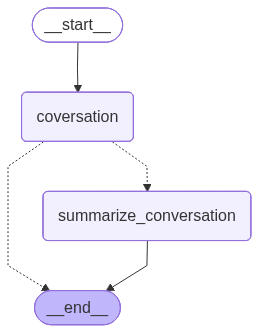

In [23]:
from IPython.display import Image, display
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START

# Define a new graph
workflow = StateGraph(State)
workflow.add_node("coversation",call_model)
workflow.add_node(summarize_conversation)

# Set the entrypoint as coversation
workflow.add_edge(START, "coversation")
workflow.add_conditional_edges("coversation",should_continue)
workflow.add_edge("summarize_conversation",END)

# Compile
memory = MemorySaver()
graph = workflow.compile(checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

## Threads

The checkpointer saves the state at each step as a checkpoint.

These saved checkpoints can be grouped into a `thread` of conversation.

Think about Slack as an analog: different channels carry different conversations.

Threads are like Slack channels, capturing grouped collections of state (e.g., conversation).

Below, we use `configurable` to set a thread ID.

![state.jpg](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbadf3b379c2ee621adfd1_chatbot-summarization1.png)

In [24]:
# Create a thread
config = {"configurable":{"thread_id":"1"}}

# Start conversation
input_message = HumanMessage(content="hi! I'm Tharun")
output = graph.invoke({"messages":[input_message]},config)
for m in output["messages"][-1:]:
  m.pretty_print()

input_message = HumanMessage(content="what's my name?")
output = graph.invoke({"messages":[input_message]},config)
for m in output["messages"][-1:]:
  m.pretty_print()

input_message = HumanMessage(content="i like the Indian cricket team!")
output = graph.invoke({"messages":[input_message]},config)
for m in output["messages"][-1:]:
  m.pretty_print()

================================== Ai Message ==================================

Hi Tharun! Nice to meet you.

I'm an AI assistant. How can I help you today?
================================== Ai Message ==================================

Your name is Tharun.
================================== Ai Message ==================================

That's great to hear, Tharun! They're a fantastic team with a rich history and a huge following.

Do you have a favorite player, or a particular series or match that stands out for you?


Now, we don't yet have a summary of the state because we still have < = 6 messages.

This was set in `should_continue`.

```
    # If there are more than six messages, then we summarize the conversation
    if len(messages) > 6:
        return "summarize_conversation"
```

We can pick up the conversation because we have the thread.

In [25]:
graph.get_state(config).values.get("summary","")

''

The `config` with thread ID allows us to proceed from the previously logged state!

In [26]:
input_message = HumanMessage(content="i like virat Kohli, isn't he the highest paid player?")
output = graph.invoke({"messages":[input_message]},config)
for m in output["messages"][-1:]:
  m.pretty_print()

================================== Ai Message ==================================

Virat Kohli is an excellent choice, Tharun! He's an absolute legend of the game and one of the most influential cricketers of his generation.

Regarding him being the highest-paid player, it's a bit nuanced but generally **yes, he is consistently among the highest-paid, if not *the* highest-paid, cricketer globally.**

Here's why:

1.  **IPL Contract:** He commands one of the highest salaries in the Indian Premier League (IPL) from Royal Challengers Bangalore.
2.  **BCCI Contract:** He's in the top A+ category for the Board of Control for Cricket in India (BCCI) central contracts, which means a very high annual retainer and match fees.
3.  **Endorsements:** This is where he truly stands out. Virat Kohli has an incredible brand value and an extensive portfolio of endorsement deals with major international and Indian brands (like Puma, MRF, Audi, Tissot, Manyavar, etc.). His earnings from endorsements far s

In [27]:
graph.get_state(config).values.get("summary","")

"Here's a summary of our conversation so far:\n\nThe conversation began with you, Tharun, introducing yourself. I acknowledged your name and then confirmed it when you asked. You then shared your liking for the Indian cricket team, specifically mentioning Virat Kohli as your favorite player. You also asked if Virat Kohli is the highest-paid player, to which I explained that he is consistently among the highest-paid globally, primarily due to his IPL and BCCI contracts, and significantly, his extensive and lucrative endorsement deals."